# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn.decomposition import PCA
import sklearn.preprocessing as pp
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import RFE

from xgboost import XGBRegressor

from scipy.stats import chi2_contingency

import umap

import pickle

from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from geopy.geocoders import Nominatim

from IPython.display import HTML, Image

import time
time_init = time.time()

## 0.1 Loading Dataset

In [2]:
prices = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Price_AV_Itapema.csv', low_memory=False)
vivareal = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\VivaReal_Itapema.csv')
details = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Details_Data.csv')
hosts = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Hosts_ids_Itapema.csv')

## 0.2 Helper Functions

In [3]:
# tranform lat long in address
def get_district(x):
    geolocator = Nominatim(user_agent="geoapiExercises")
    lat = str(x[0])
    long = str(x[1])
    location = geolocator.reverse(lat+","+long, timeout=None)
    return location

# search outliers and limits
def search_outliers(df, series):
    q1 = np.percentile(df[series], 25)
    q3 = np.percentile(df[series], 75)
    distancia = q3 - q1
    salto = distancia * 1.5
    li = q1 - salto
    ls = q3 + salto
    indices = df[(df[series]<li)|(df[series]>ls)].index
    return indices, li, ls

# correlations between categorical attributes by Pearson method
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    return round(np.sqrt((chi2corr/n)/( min(kcorr-1, rcorr-1))), 2)


def metrics(y_test, y_hat):
    # metrics
    mean_absolute_error = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_hat))) # mean absolute error
#     mean_absolute_percentage_error = np.mean(mean_absolute_error / np.expm1(y_test)) # mean absolute percentage error

    print(f"MAE: {mean_absolute_error}")
#     print(f"MAPE: {mean_absolute_percentage_error}")
    print(f"RMSE: {np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_hat)))}")

    

def cross_validation(df, error, kfold, model_name, model):
    list_mean_absolute_error, list_mean_absolute_percentage_error, list_root_mean_squared_error, folds = [], [], [], []
    for i in reversed(range(1, kfold+1)):
        folds.append(f'Fold: {i}')
        validation_start_date = df['date'].max() - pd.Timedelta(6*i, 'w')
        validation_end_date = df['date'].max() - pd.Timedelta(6*(i-1), 'w')
        
        train = df[df['date']<validation_start_date]
        validation = df[(df['date']>=validation_start_date)&(df['date']<=validation_end_date)]
        
        X_train = train.drop(['revenue', 'date'], axis=1)
        y_train = train['revenue']
        
        X_val = validation.drop(['revenue', 'date'], axis=1)
        y_val = validation['revenue']
        
        # fiting model
        model_fit = model.fit(X_train, y_train)

        # predicting
        y_hat = model_fit.predict(X_val)
        
        list_mean_absolute_error.append(np.mean(np.abs(np.expm1(y_val) - np.expm1(y_hat))))
        list_mean_absolute_percentage_error.append(np.mean(np.abs(np.expm1(y_val) - np.expm1(y_hat)) / np.expm1(y_val)))
        list_root_mean_squared_error.append(np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_hat))))
        
    # mean and std
    folds.append('mean_and_std')
    list_mean_absolute_error.append(str(round(np.mean(list_mean_absolute_error), 2))+' +/- '+str(round(np.std(list_mean_absolute_error), 2)))
    list_mean_absolute_percentage_error.append(str(round(np.mean(list_mean_absolute_percentage_error), 2))+' +/- '+str(round(np.std(list_mean_absolute_percentage_error), 2)))
    list_root_mean_squared_error.append(str(round(np.mean(list_root_mean_squared_error), 2))+' +/- '+str(round(np.std(list_root_mean_squared_error), 2)))
    # dataframe
    cross_validation_metrics = pd.DataFrame([list_mean_absolute_error, list_mean_absolute_percentage_error, list_root_mean_squared_error], index=['MAE', 'MAPE', "RMSE"], columns=folds)
    error[model_name] = cross_validation_metrics['mean_and_std']
    return error, cross_validation_metrics

# 1.0 Data Description

## 1.1 Looking Datasets

In [4]:
prices.head()

,airbnb_listing_id,date,price,price_string,minimum_stay,available,aquisition_date,av_for_checkin,av_for_checkout,index,bookable,ano,mes,dia
0,22258063,2022-11-27,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
1,22258063,2022-11-28,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
2,22258063,2022-11-29,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
3,22258063,2022-11-30,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
4,22258063,2022-12-01,500.0,R$500,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27


In [5]:
vivareal.head(3)

,listing_id,link_name,link_url,listing_type,listing_title,listing_desc,business_types,unit_type,unit_subtype,property_type,...,advertiser_id,advertiser_name,advertiser_phones,advertiser_whatsapp,advertiser_url,portal,aquisition_date,ano,mes,dia
0,2570403797,"Apartamento com 4 Quartos à venda, 187m²",https://www.vivareal.com.br/imovel/apartamento...,USED,"Apartamento com 4 dormitórios à venda, 187 m² ...",Situado em uma das melhores regiões da Meia Pr...,"[""SALE""]",APARTMENT,NaN,UNIT,...,39507409-01f8-3935-dc38-e0fea684b44a,Winner Brokers,"[""44984349088""]",4.498435e+10,https://www.vivareal.com.br/770696/winner-brok...,GRUPOZAP,2022-12-06 00:00:00.000,2022,12,6
1,2510420914,"Apartamento com 4 Quartos à venda, 253m²",https://www.vivareal.com.br/imovel/apartamento...,USED,Apartamento com 4 suítes 3 vagas em Itapema SC,"Apartamentos com 04 suítes, 03 vagas de garage...","[""SALE""]",APARTMENT,NaN,UNIT,...,cc5bc87d-b746-8b05-90f8-ef61f5020a69,FRANCA FERRAZ IMOBILIARIA,"[""4733630740"", ""47996961130""]",4.799696e+10,https://www.vivareal.com.br/116267/franca-ferr...,GRUPOZAP,2022-12-06 00:00:00.000,2022,12,6
2,2594648655,"Apartamento com 4 Quartos à venda, 210m²",https://www.vivareal.com.br/imovel/apartamento...,USED,"Apartamento à venda, Centro, Itapema, SC","Apartamento à Venda, 210m² por R$ 3.000.000. C...","[""SALE""]",APARTMENT,NaN,UNIT,...,ac9f84ae-1363-d2aa-1a6d-4adf1631539f,ARBO IMÓVEIS,"[""11999293012""]",1.199929e+10,https://www.vivareal.com.br/656548/arbo-imoveis/,GRUPOZAP,2022-12-06 00:00:00.000,2022,12,6


In [6]:
details.head(3)

,aquisition_date,url,ad_name,ad_description,ad_id,space,house_rules,amenities,safety_features,number_of_bathrooms,...,index,localized_star_rating,response_time_shown,response_rate_shown,guest_satisfaction_overall,picture_count,min_nights,ano,mes,dia
0,2022-07-11 07:21:51.61831,https://www.airbnb.com.br/rooms/27865733,Carambei 106,"Apartamento para 8 pessoas, lateral p praia. P...",27865733,Espaco TOP tipo hotel,"{""Não são permitidas festas ou eventos"",""Anima...","{Cabides,""Ferro de passar"",""Máquina de Lavar"",...",{},2.0,...,11043701.0,NaN,em até uma hora,100%,100.0,31.0,2.0,2022,7,11
1,2022-07-11 07:28:25.226756,https://www.airbnb.com.br/rooms/52200210,Apto aconchegante na rua + procurada da Meia P...,Sua família vai estar perto de tudo ao ficar n...,52200210,NaN,"{""Animais de estimação são permitidos""}","{""Máquina de Lavar"",TV,Ar-condicionado,Wi-Fi,""...",{},2.0,...,11082903.0,"5,0",em até uma hora,100%,100.0,43.0,2.0,2022,7,11
2,2022-07-18 07:19:40.053547,https://www.airbnb.com.br/rooms/53372578,Ótimo apartamento em Itapema,Ótimo para período de férias,53372578,"O Ap é bastante amplo, sala de star e jantar i...","{""Animais de estimação são permitidos""}","{""Local para guardar as roupas"",""Blackout nas ...","{""Extintor de incêndio""}",2.0,...,11300813.0,"3,0",NaN,NaN,60.0,11.0,7.0,2022,7,18


In [7]:
hosts.head(3)

,host_id,host_name,host_rating,n_reviews,n_reviews_from_host,n_listings,about_host,comments,aquisition_date,ano,mes,dia
0,160913639,Cayo,0.000,0,0,1,NaN,NaN,2022-12-05,2022,12,5
1,84162292,Ricardo,4.935,42,1,3,"Sou casado, tenho uma filha de 9 anos e um fil...","[""Obrigado Ricardo a estadia foi ótima muito ...",2022-12-05,2022,12,5
2,96045548,Eduardo,0.000,26,0,3,NaN,"[""Otimo"", ""muito bom local e muito claro nas e...",2022-12-05,2022,12,5


## 1.2 Data Dimensions

In [8]:
print('prices')
print(f'Rows qtd: {prices.shape[0]}')
print(f'Columns qtd: {prices.shape[1]}\n')
print('vivareal')
print(f'Rows qtd: {vivareal.shape[0]}')
print(f'Columns qtd: {vivareal.shape[1]}\n')
print('details')
print(f'Rows qtd: {details.shape[0]}')
print(f'Columns qtd: {details.shape[1]}\n')
print('hosts')
print(f'Rows qtd: {hosts.shape[0]}')
print(f'Columns qtd: {hosts.shape[1]}\n')

prices
Rows qtd: 43020080
Columns qtd: 14

vivareal
Rows qtd: 17547
Columns qtd: 42

details
Rows qtd: 32558
Columns qtd: 37

hosts
Rows qtd: 1357
Columns qtd: 12



## 1.3 Datatypes

In [9]:
prices.dtypes

airbnb_listing_id      int64
date                  object
price                float64
price_string          object
minimum_stay           int64
available               bool
aquisition_date       object
av_for_checkin        object
av_for_checkout      float64
index                float64
bookable             float64
ano                    int64
mes                    int64
dia                    int64
dtype: object

In [10]:
hosts.dtypes

host_id                  int64
host_name               object
host_rating            float64
n_reviews                int64
n_reviews_from_host      int64
n_listings               int64
about_host              object
comments                object
aquisition_date         object
ano                      int64
mes                      int64
dia                      int64
dtype: object

In [11]:
details.dtypes

aquisition_date                object
url                            object
ad_name                        object
ad_description                 object
ad_id                           int64
space                          object
house_rules                    object
amenities                      object
safety_features                object
number_of_bathrooms           float64
number_of_bedrooms            float64
number_of_beds                float64
latitude                      float64
longitude                     float64
star_rating                   float64
additional_house_rules         object
owner                          object
check_in                       object
check_out                      object
number_of_guests                int64
is_superhost                     bool
number_of_reviews               int64
cohosts                        object
cleaning_fee                  float64
can_instant_book                 bool
owner_id                        int64
listing_type

In [12]:
vivareal.dtypes

listing_id                 int64
link_name                 object
link_url                  object
listing_type              object
listing_title             object
listing_desc              object
business_types            object
unit_type                 object
unit_subtype              object
property_type             object
usage_type                object
sale_price               float64
rental_price             float64
rental_period             object
yearly_iptu              float64
monthly_condo_fee        float64
amenities                 object
usable_area              float64
total_area               float64
bathrooms                float64
bedrooms                 float64
suites                   float64
parking_spaces           float64
address_country           object
address_state             object
address_city              object
address_neighborhood      object
address_street            object
address_street_number     object
address_complement       float64
address_zi

## 1.4 Check Na

In [13]:
round(prices.isna().sum() / prices['airbnb_listing_id'].count() * 100, 2)

airbnb_listing_id      0.00
date                   0.00
price                  0.01
price_string           0.00
minimum_stay           0.00
available              0.00
aquisition_date        0.00
av_for_checkin         0.09
av_for_checkout      100.00
index                100.00
bookable             100.00
ano                    0.00
mes                    0.00
dia                    0.00
dtype: float64

In [14]:
round(hosts.isna().sum() / hosts['host_id'].count() * 100, 2)

host_id                 0.00
host_name               0.00
host_rating             0.00
n_reviews               0.00
n_reviews_from_host     0.00
n_listings              0.00
about_host             76.05
comments               21.81
aquisition_date         0.00
ano                     0.00
mes                     0.00
dia                     0.00
dtype: float64

In [15]:
round(details.isna().sum() / details['aquisition_date'].count() * 100, 2)

aquisition_date                0.00
url                            0.00
ad_name                        0.00
ad_description                 5.75
ad_id                          0.00
space                         47.46
house_rules                    9.48
amenities                      0.00
safety_features                0.00
number_of_bathrooms            0.23
number_of_bedrooms             1.59
number_of_beds                 0.57
latitude                       0.00
longitude                      0.00
star_rating                   47.69
additional_house_rules        57.24
owner                          0.00
check_in                       8.31
check_out                     20.60
number_of_guests               0.00
is_superhost                   0.00
number_of_reviews              0.00
cohosts                       87.16
cleaning_fee                   0.00
can_instant_book               0.00
owner_id                       0.00
listing_type                   0.00
index                       

In [16]:
round(vivareal.isna().sum() / vivareal['listing_id'].count() * 100, 2)

listing_id                 0.00
link_name                  0.00
link_url                   0.00
listing_type               0.00
listing_title              0.06
listing_desc               0.54
business_types             0.00
unit_type                  0.00
unit_subtype              98.66
property_type              0.00
usage_type                 0.00
sale_price                 6.42
rental_price              93.35
rental_period             93.35
yearly_iptu               56.64
monthly_condo_fee         56.39
amenities                  0.00
usable_area                0.03
total_area                11.81
bathrooms                  0.23
bedrooms                   0.51
suites                     7.06
parking_spaces             4.47
address_country            0.00
address_state              0.00
address_city               0.00
address_neighborhood       5.37
address_street            38.38
address_street_number     41.03
address_complement       100.00
address_zipcode            0.10
location

## 1.5 Fillout Na

In [17]:
map_bedrooms_by_guests = details.groupby('number_of_guests').agg({'number_of_bedrooms':'mean'})['number_of_bedrooms'].round()
temp = details.loc[details['number_of_bedrooms'].isna(), 'number_of_guests'].map(map_bedrooms_by_guests).values
details.loc[details['number_of_bedrooms'].isna(), 'number_of_bedrooms'] = temp

map_bathrooms_by_guests = details.groupby('number_of_guests').agg({'number_of_bathrooms':'mean'})['number_of_bathrooms'].round()
temp = details.loc[details['number_of_bathrooms'].isna(), 'number_of_guests'].map(map_bathrooms_by_guests).values
details.loc[details['number_of_bathrooms'].isna(), 'number_of_bathrooms'] = temp

map_beds_by_guests = details.groupby('number_of_guests').agg({'number_of_beds':'mean'})['number_of_beds'].round()
temp = details.loc[details['number_of_beds'].isna(), 'number_of_guests'].map(map_beds_by_guests).values
details.loc[details['number_of_beds'].isna(), 'number_of_beds'] = temp

## 1.6 Rename Columns

In [18]:
prices.rename(columns={'airbnb_listing_id':'airbnb_id'}, inplace=True)
details.rename(columns={'ad_id':'airbnb_id'}, inplace=True)

## 1.7 Data Cleaning I

### 1.7.1 prices

#### 1.7.1 duplicates

In [19]:
prices = prices[~prices[['airbnb_id', 'date']].duplicated()]

#### 1.7.2 available

In [20]:
prices['available'] = prices['available'].apply(lambda x: 1 if x==True else 0)

### 1.7.2 details

#### 1.7.2.1 safety_features

In [21]:
details['safety_features'] = details['safety_features'].apply(lambda x: re.sub('[^a-zA-Z0-9\n.çêó]', ' ', x))
details['safety_features'] = details['safety_features'].str.replace(' ', '')
details['safety_features'] = details['safety_features'].str.replace('Trancanaportadoquarto','')
details['safety_features'] = details['safety_features'].str.replace('u00ea', 'ê')
details['safety_features'] = details['safety_features'].str.replace('u00e7', 'ç')
details['safety_features'] = details['safety_features'].str.replace('u00f3', 'ó')

#### 1.7.2.2 amenities

In [22]:
details['amenities'] = details['amenities'].apply(lambda x: re.sub('[^a-zA-ZÁáíêç]', '', x))
details['amenities'] = details['amenities'].apply(lambda x: x.replace('Extintordeincêndio', ''))
details['amenities'] = details['amenities'].apply(lambda x: x.replace('Detectordefumaça', ''))
details['amenities'] = details['amenities'].apply(lambda x: x.replace('Kitdeprimeirossocorros', ''))
details['amenities'] = details['amenities'].apply(lambda x: x.replace('Trancanaportadoquarto', ''))
details['amenities'] = details['amenities'].apply(lambda x: x.replace('Águaquente', ''))
details['amenities'] = details['amenities'].apply(lambda x: x.replace('Cabides', ''))

## 1.8 Changing Datatypes

In [23]:
# prices
prices['available'] = prices['available'].astype(int)
prices['date'] = pd.to_datetime(prices['date'])

# details
details['number_of_bathrooms'] = details['number_of_bathrooms'].astype(int)
details['number_of_bedrooms'] = details['number_of_bedrooms'].astype(int)
details['number_of_beds'] = details['number_of_beds'].astype(int)

## 1.9 Integrating Dataframes

### 1.9.1 Merging

In [24]:
df = prices[['airbnb_id', 'date', 'price', 'available']]

temp = details[['airbnb_id', 'cleaning_fee', 'number_of_bathrooms', 'number_of_bedrooms', 'number_of_beds', 'number_of_guests', 'safety_features', 'amenities', 'latitude', 'longitude', 'listing_type', 'ad_description', 'ad_name', 'space']]
temp = temp.groupby('airbnb_id').agg({'cleaning_fee':'median', 'number_of_bathrooms':'median', 'number_of_bedrooms':'median', 'number_of_beds':'median', 'number_of_guests':'median', 'safety_features':'first', 'amenities':'first', 'latitude':'first', 'longitude':'first', 'listing_type':'first', 'ad_description':'first', 'ad_name':'first', 'space':'first'})

df = pd.merge(df, temp, on='airbnb_id', how='left')

### 1.9.2 Data Dimension

In [25]:
print(f'Quantity of rows: {df.shape[0]}')
print(f'Quantity of columns: {df.shape[1]}')

Quantity of rows: 968832
Quantity of columns: 17


### 1.9.3 Check Na

In [26]:
df.isna().sum() / df['airbnb_id'].count()

airbnb_id              0.000000
date                   0.000000
price                  0.000029
available              0.000000
cleaning_fee           0.000000
number_of_bathrooms    0.000000
number_of_bedrooms     0.000000
number_of_beds         0.000000
number_of_guests       0.000000
safety_features        0.000000
amenities              0.000000
latitude               0.000000
longitude              0.000000
listing_type           0.000000
ad_description         0.049710
ad_name                0.000000
space                  0.507706
dtype: float64

## 1.10 Descriptive Statistical

In [27]:
num_attributes = ['price', 'cleaning_fee']

### 1.10.1 Numerical Attributes

In [28]:
# Central tendency
ct1 = pd.DataFrame(df[num_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(df[num_attributes].apply(np.median)).T

# Dispersion
d1 = pd.DataFrame(df[num_attributes].apply(np.std)).T
d2 = pd.DataFrame(df[num_attributes].apply(min)).T
d3 = pd.DataFrame(df[num_attributes].apply(max)).T
d4 = pd.DataFrame(df[num_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df[num_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df[num_attributes].apply(lambda x: x.kurtosis())).T

# Concat
temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
price,48.0,500900.0,500852.0,953.390411,NaN,7906.074159,41.759276,2063.143521
cleaning_fee,0.0,1200.0,1200.0,191.087396,200.0,111.185483,0.543377,4.043620


* price com média e mediana completamente deslocadas, skew alta, kurtosis enorme, indícios de outliers muito elevados.
* cleaning fee com valores zerados, com distribuição aparentemente normal.

In [29]:
df[num_attributes].describe()

,price,cleaning_fee
count,968804.000000,968832.000000
mean,953.390411,191.087396
std,7906.078239,111.185541
min,48.000000,0.000000
25%,310.000000,150.000000
50%,500.000000,200.000000
75%,800.000000,250.000000
max,500900.000000,1200.000000


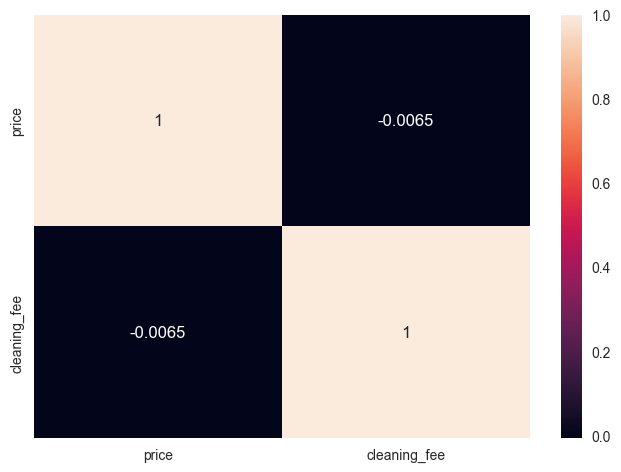

In [30]:
sns.heatmap(df[num_attributes].corr(), annot=True);

* Correlação inexistente entre cleaning_fee e price

### 1.10.2 Categorical Attributes

In [31]:
cat_attributes = ['available', 'number_of_bathrooms', 'number_of_bedrooms', 'number_of_beds', 'number_of_guests']

In [32]:
df[cat_attributes].apply(lambda x: x.nunique())

available               2
number_of_bathrooms     9
number_of_bedrooms     10
number_of_beds         23
number_of_guests       18
dtype: int64

In [33]:
temp = df[cat_attributes].copy()

for i in cat_attributes:
    temp[i] = temp[i].astype(str)

In [34]:
temp.describe().T

,count,unique,top,freq
available,968832,2,1,611823
number_of_bathrooms,968832,9,2.0,495298
number_of_bedrooms,968832,10,3.0,431425
number_of_beds,968832,23,3.0,294739
number_of_guests,968832,18,6.0,265772


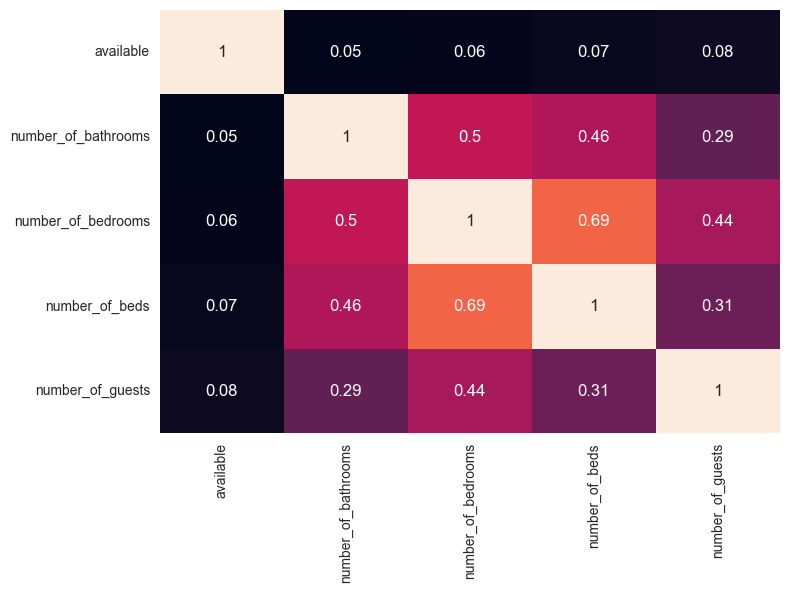

In [35]:
cramer_correlation = []

for i, col_1 in enumerate(cat_attributes):
    for j, col_2 in enumerate(cat_attributes):
        cramer_correlation.append(cramer_v(df[col_1], df[col_2]))
        
matrix = pd.DataFrame(np.array(cramer_correlation).reshape(5, 5), index=cat_attributes, columns=cat_attributes)

sns.heatmap(matrix, annot=True, cbar=False);

* guests, bedrooms, bathrooms and bads high correlated

## 1.11 Data Cleaning II

### 1.11.1 price

In [36]:
# fillout NA
df.loc[df['price'].isna(), 'price'] = df.loc[df['price'].isna(), 'cleaning_fee'] * 2

In [37]:
ix, li, ls = search_outliers(df , 'price')
map_price_median_airbnb_id = df.groupby('airbnb_id').agg({'price':'median'})['price']
before = len(df.loc[df['price']>=ls, 'price'])
print(f'Before treatment: {before}')
df.loc[df['price']>=ls, 'price'] = df.loc[df['price']>=ls, 'airbnb_id'].map(map_price_median_airbnb_id)
print(f"After treatment: {len(df.loc[df['price']>=ls, 'price'])}")
print(f"{round((before - len(df.loc[df['price']>=ls, 'price'])) / before * 100)}% of total")

Before treatment: 63602
After treatment: 55882
12% of total


In [38]:
map_price_min_airbnb_id = df.groupby('airbnb_id').agg({'price':'min'})['price']
before = len(df.loc[df['price']>=ls, 'price'])
print(f'Before treatment: {before}')
df.loc[df['price']>=ls, 'price'] = df.loc[df['price']>=ls, 'airbnb_id'].map(map_price_min_airbnb_id)
print(f"After treatment: {len(df.loc[df['price']>=ls, 'price'])}")
print(f"{round((before - len(df.loc[df['price']>=ls, 'price'])) / before * 100)}% of total")

Before treatment: 55882
After treatment: 41776
25% of total


In [39]:
ix, li, ls = search_outliers(df, 'price')
before = len(df.loc[df['price']>=ls, 'price'])
print(f'Before treatment: {before}')
df.loc[ix, 'price'] = df.loc[(ix), 'cleaning_fee'] * 2
print(f"After treatment: {len(df.loc[df['price']>=ls, 'price'])}")
print(f"{round((before - len(df.loc[df['price']>=ls, 'price'])) / before * 100)}% of total")

Before treatment: 41776
After treatment: 424
99% of total


### 1.11.2 cleaning_fee

In [40]:
df.loc[df['cleaning_fee']==0, 'cleaning_fee'] = df.loc[df['cleaning_fee']==0, 'price'] / 2

# 2.0 Data Filtering

## 2.1 Columns Filtering

## 2.2 Rows Filtering

### 2.2.1 price

In [41]:
ix, li, ls = search_outliers(df, 'price')

In [42]:
df.loc[ix, 'price'] = df.loc[ix, 'price'].clip(upper=1600)

### 2.2.2 FiIlout NA

In [43]:
df.dropna(inplace=True)

# 3.0 Feature Engineering

## 3.1 details

### 3.1.1 safety_features dummies

In [44]:
temp = 'Extintordeincêndio Detectordefumaça Alarmedemonóxidodecarbono Kitdeprimeirossocorros'.split()
df['extintordeincendio'] = df['safety_features'].apply(lambda x: 1 if temp[0] in x else 0)
df['detectordefumaça'] = df['safety_features'].apply(lambda x: 1 if temp[1] in x else 0)
df['alarmedemonoxidodecarbono'] = df['safety_features'].apply(lambda x: 1 if temp[2] in x else 0)
df['kitdeprimeirossocorros'] = df['safety_features'].apply(lambda x: 1 if temp[3] in x else 0)
df.drop('safety_features', axis=1, inplace=True)

### 3.1.2 amenities dummies

In [45]:
temp = 'MáquinadeLavar TV Arcondicionado WiFi Cozinha Churrasqueira Estacionamentoincluído Chuveiroexterno Elevador Ferrodepassar'.split()

df['MáquinadeLavar'] = df['amenities'].apply(lambda x: 1 if temp[0] in x else 0)
df['TV'] = df['amenities'].apply(lambda x: 1 if temp[1] in x else 0)
df['Arcondicionado'] = df['amenities'].apply(lambda x: 1 if temp[2] in x else 0)
df['WiFi'] = df['amenities'].apply(lambda x: 1 if temp[3] in x else 0)
df['Cozinha'] = df['amenities'].apply(lambda x: 1 if temp[4] in x else 0)
df['Churrasqueira'] = df['amenities'].apply(lambda x: 1 if temp[5] in x else 0)
df['Estacionamentoincluído'] = df['amenities'].apply(lambda x: 1 if temp[6] in x else 0)
df['Chuveiroexterno'] = df['amenities'].apply(lambda x: 1 if temp[7] in x else 0)
df['Elevador'] = df['amenities'].apply(lambda x: 1 if temp[8] in x else 0)
df['Ferrodepassar'] = df['amenities'].apply(lambda x: 1 if temp[9] in x else 0)
df.drop('amenities', axis=1, inplace=True)

### 3.1.3 neighborhood

In [46]:
ref = df.groupby('airbnb_id').agg({'latitude':'first', 'longitude':'first'}).reset_index()
# temp = ref.iloc[0:500][['latitude', 'longitude']].apply(lambda x: get_district(x), axis=1)
# temp1 = ref.iloc[500:1000][['latitude', 'longitude']].apply(lambda x: get_district(x), axis=1)
# temp2 = ref.iloc[1000:1500][['latitude', 'longitude']].apply(lambda x: get_district(x), axis=1)
# temp3 = ref.iloc[1500:][['latitude', 'longitude']].apply(lambda x: get_district(x), axis=1)
# address = [temp, temp1, temp2, temp3]
# pickle.dump(address, open('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\interim\\address.pkl', 'wb'))
# time.sleep(30)
address = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\interim\\address.pkl', 'rb'))
ref['address'] = address[0].append(address[1]).append(address[2]).append(address[3])
ref['neighborhood'] = ref['address'].apply(lambda x: x[0].split(',')[1])
neighborhood_list = ref['neighborhood'].value_counts().keys().to_list()
neighborhood = []

for i in neighborhood_list:
    i = i.replace(' ', '')
    if i.isalpha():
        neighborhood.append(i)

neighborhood.extend(['VilaNova', 'RioPequeno'])
temp = 'Areal RegiãoGeográficaImediatadeItajaí RuaGuilhermeMarian RuaJoséAlexandreRocha RuaBeijaFlor RodoviaGovernadorMárioCovas RuaIgrejaEvangélicaAssembleiadeDeus AvenidaGovernadorCelsoRamos AvenidaNereuRamos LoteamentoItapema'.split()

for i in temp:
    try:
        bairros.remove(i)
    except:
        pass

def neighborhood_clean(x):
    x = x[0].replace(' ', '')
    for i in neighborhood:
        if i in x:
            return i

ref['neighborhood'] = ref['address'].apply(lambda x: neighborhood_clean(x))
df = pd.merge(df, ref[['airbnb_id', 'neighborhood']], on='airbnb_id', how='left')
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

C:\Users\Samoel\AppData\Local\Temp\ipykernel_4292\3960031341.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ref['address'] = address[0].append(address[1]).append(address[2]).append(address[3])


### 3.1.4 unit_type

In [47]:
apartment = df['listing_type'].dropna().apply(lambda x: 'apartamento' in x.lower() or 'apto' in x.lower() or 'ap' in x.lower() or 'cobertura' in x.lower() or 'duplex' in x.lower() or 'triplex' in x.lower())
apartment = list(df['listing_type'].dropna().loc[apartment].index)
home = df['listing_type'].dropna().apply(lambda x: 'casa' in x.lower() or 'sobrado' in x.lower())
home = list(df['listing_type'].dropna().loc[home].index)
both = list(set(apartment)&set(home))
home = list(set(home) - set(both))
df.loc[home, 'unit_type'] = 'HOME'
df.loc[apartment, 'unit_type'] = 'APARTMENT'

apartment = df['ad_description'].dropna().apply(lambda x: 'apartamento' in x.lower() or 'apto' in x.lower() or 'ap' in x.lower() or 'cobertura' in x.lower() or 'duplex' in x.lower() or 'triplex' in x.lower())
apartment = list(df['ad_description'].dropna().loc[apartment].index)
home = df['ad_description'].dropna().apply(lambda x: 'casa' in x.lower() or 'sobrado' in x.lower())
home = list(df['ad_description'].dropna().loc[home].index)
both = list(set(apartment)&set(home))
home = list(set(home) - set(both))
df.loc[home, 'unit_type'] = 'HOME'
df.loc[apartment, 'unit_type'] = 'APARTMENT'

apartment = df['ad_name'].dropna().apply(lambda x: 'apartamento' in x.lower() or 'apto' in x.lower() or 'ap' in x.lower() or 'cobertura' in x.lower() or 'duplex' in x.lower() or 'triplex' in x.lower())
apartment = list(df['ad_name'].dropna().loc[apartment].index)
home = df['ad_name'].dropna().apply(lambda x: 'casa' in x.lower() or 'sobrado' in x.lower())
home = list(df['ad_name'].dropna().loc[home].index)
both = list(set(apartment)&set(home))
home = list(set(home) - set(both))
df.loc[home, 'unit_type'] = 'HOME'
df.loc[apartment, 'unit_type'] = 'APARTMENT'

apartment = df['space'].dropna().apply(lambda x: 'apartamento' in x.lower() or 'apto' in x.lower() or 'ap' in x.lower() or 'cobertura' in x.lower() or 'duplex' in x.lower() or 'triplex' in x.lower())
apartment = list(df['space'].dropna().loc[apartment].index)
home = df['space'].dropna().apply(lambda x: 'casa' in x.lower() or 'sobrado' in x.lower())
home = list(df['space'].dropna().loc[home].index)
both = list(set(apartment)&set(home))
home = list(set(home) - set(both))
df.loc[home, 'unit_type'] = 'HOME'
df.loc[apartment, 'unit_type'] = 'APARTMENT'
df.drop(['listing_type', 'ad_description', 'ad_name', 'space'], axis=1, inplace=True)

## 3.2 vivareal

### 3.2.1 badrooms and area

In [48]:
vivareal['bedrooms'] = vivareal['link_name'].apply(lambda x: re.sub('[^0-9,]', '', x)).apply(lambda x: x.split(',')[0])
vivareal['area'] = vivareal['link_name'].apply(lambda x: re.sub('[^0-9,]', '', x)).apply(lambda x: x.split(',')[-1])

def vivareal_area_or_bedrooms(x):
    bedrooms = x[0]
    if len(bedrooms) >= 3:
        area = bedrooms[1:]
        bedrooms = bedrooms[0]
    else:
        area = x[1]
    return bedrooms, area
        
temp = vivareal[['bedrooms', 'area']].apply(vivareal_area_or_bedrooms, axis=1)
vivareal['bedrooms'] = temp.str[0]
vivareal['area'] = temp.str[1]

# Fillout empty values and outliers
vivareal = vivareal[vivareal['area']!='']
vivareal = vivareal[vivareal['bedrooms']!='']

# Changing Datatypes
vivareal['area'] = vivareal['area'].astype(int)
vivareal['bedrooms'] = vivareal['bedrooms'].astype(int)

# Fillout outliers
ix = vivareal[vivareal['area']>1000].index
vivareal.drop(ix, axis=0, inplace=True)

ix = vivareal.loc[vivareal['bedrooms']>=8].index
vivareal.drop(ix, inplace=True)

## 3.3 df

In [49]:
# revenue
df.loc[df['available']==0, 'revenue'] = df.loc[df['available']==0, 'price']
df.loc[df['revenue'].isna(), 'revenue'] = 0
df['revenue'] = df['revenue'].astype(int)

# area
area_bedroom_mean = vivareal.groupby('bedrooms').agg({'area':'median'})['area']
df['area'] = df['number_of_bedrooms'].map(area_bedroom_mean)

# year
df['year'] = df['date'].dt.year

# month
df['month'] = df['date'].dt.month

# week of year
df['week_of_year'] = df['date'].dt.isocalendar().week

# day
df['day'] = df['date'].dt.day

In [50]:
df.loc[df['unit_type'].isna(), 'unit_type'] = 'other'
df.loc[df['area'].isna(), 'area'] = df['area'].median()

## 3.4 Lifetime value (RFM)

In [51]:
# data reference
df_ref = df[['airbnb_id']].drop_duplicates(ignore_index=True)

# lifetime value
# monetary
temp = df.groupby('airbnb_id').agg({'revenue':'sum'}).reset_index().rename(columns=({'revenue':'gross_revenue'}))
df_ref = pd.merge(df_ref, temp, on='airbnb_id', how='left')

# recency
max_date = prices['date'].max().strftime('%Y-%m-%d')
min_date = prices['date'].min().strftime('%Y-%m-%d')
min_date = pd.to_datetime(min_date)
max_date = pd.to_datetime(max_date)
date_delta = (max_date - min_date).days + 1
temp = df.loc[df['available']==0].groupby('airbnb_id').agg({'date':'max'}).reset_index().rename(columns=({'date':'last_revenue'}))
temp['recency'] = (max_date - temp['last_revenue']).dt.days
temp.drop(['last_revenue'], axis=1, inplace=True)
df_ref = pd.merge(df_ref, temp, on='airbnb_id', how='left')

# frequency
temp = df.loc[df['available']==0].groupby('airbnb_id').agg({'price':'count'}).reset_index().rename(columns=({'price':'quantity_sell'}))
temp['frequency'] = (date_delta / temp['quantity_sell'])
temp.drop('quantity_sell', axis=1, inplace=True)
df_ref = pd.merge(df_ref, temp, on='airbnb_id', how='left')

## 3.5 Merging df_ref with df

In [52]:
temp = df.groupby('airbnb_id').median()
df_ref = pd.merge(df_ref, temp, how='left', on='airbnb_id')

temp = df.groupby('airbnb_id').agg({'unit_type':'first'})
df_ref = pd.merge(df_ref, temp, how='left', on='airbnb_id')

temp = df.groupby('airbnb_id').agg({'neighborhood':'first'})
df_ref = pd.merge(df_ref, temp, how='left', on='airbnb_id')

C:\Users\Samoel\AppData\Local\Temp\ipykernel_4292\3002604091.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby('airbnb_id').median()


## 3.6 Changing df granularity

In [53]:
cols = ('airbnb_id area price number_of_bedrooms number_of_bathrooms number_of_beds number_of_guests extintordeincendio detectordefumaça alarmedemonoxidodecarbono kitdeprimeirossocorros MáquinadeLavar TV Arcondicionado WiFi Cozinha Churrasqueira Estacionamentoincluído Chuveiroexterno Elevador Ferrodepassar week_of_year').split()
df_week = df[cols].groupby(['airbnb_id', 'week_of_year']).median().reset_index()

temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'revenue':'sum'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'available':'mean'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'neighborhood':'first'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'unit_type':'first'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'date':'first'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'year':'first'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'day':'first'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

temp = df.groupby(['airbnb_id', 'week_of_year']).agg({'month':'first'}).reset_index()
df_week = pd.merge(df_week, temp, on=['airbnb_id', 'week_of_year'], how='left')

# 4.0 Exploratory Data Analysis

## 4.1 Univariate Analysis

## 4.2 Bivariate Analysis

# 5.0 Data Preparation

## 5.1 Normalization

## 5.2 Target

In [54]:
df_week['revenue'] = np.log1p(df_week['revenue'])

mm_revenue = pp.MinMaxScaler()
mm_revenue = mm_revenue.fit(df_week[['revenue']].values)
df_week['revenue'] = mm_revenue.transform(df_week[['revenue']].values)

## 5.3 Rescaling

### 5.3.2 df

In [55]:
# price
mm_price = pp.MinMaxScaler()
mm_price = mm_price.fit(df_week[['price']].values)
df_week['price'] = mm_price.transform(df_week[['price']].values)

## 5.4 Transformation

### 5.4.1 Encoding

#### 5.4.1.1 df

In [56]:
#  'number_of_bathrooms',
map_number_of_bathrooms = df_week.groupby('number_of_bathrooms').agg({'available':'mean'})['available']
df_week['number_of_bathrooms'] = df_week['number_of_bathrooms'].map(map_number_of_bathrooms)

#  'number_of_bedrooms',
map_number_of_bedrooms = df_week.groupby('number_of_bedrooms').agg({'available':'mean'})['available']
df_week['number_of_bedrooms'] = df_week['number_of_bedrooms'].map(map_number_of_bedrooms)

#  'number_of_beds',
map_number_of_beds = df_week.groupby('number_of_beds').agg({'available':'mean'})['available']
df_week['number_of_beds'] = df_week['number_of_beds'].map(map_number_of_beds)

#  'number_of_guests',
map_number_of_guests = df_week.groupby('number_of_guests').agg({'available':'mean'})['available']
df_week['number_of_guests'] = df_week['number_of_guests'].map(map_number_of_guests)

#  'area'
map_area = df_week.groupby('area').agg({'available':'mean'})['available']
df_week['area'] = df_week['area'].map(map_area)

# 'neighborhood'
map_neighborhood = df_week.groupby('neighborhood').agg({'available':'mean'})['available']
df_week['neighborhood'] = df_week['neighborhood'].map(map_neighborhood)

# 'unit_type'
map_unit_type = df_week.groupby('unit_type').agg({'available':'mean'})['available']
df_week['unit_type'] = df_week['unit_type'].map(map_unit_type)

# 'day'
map_day = df_week.groupby('day').agg({'available':'mean'})['available']
df_week['day'] = df_week['day'].map(map_day)

# 'year'
map_year = df_week.groupby('year').agg({'available':'mean'})['available']
df_week['year'] = df_week['year'].map(map_year)

# 'month'
map_month = df_week.groupby('month').agg({'available':'mean'})['available']
df_week['month'] = df_week['month'].map(map_month)

## 5.5 Preprocessing

## 5.6 Splits

In [57]:
df_ref.dropna(inplace=True)
X = df_ref[['gross_revenue', 'recency', 'frequency']]

In [58]:
# Train and Validation
X_train = df_week.loc[df_week['date'] < df_week['date'].max() - pd.Timedelta(6, 'w')].drop(['revenue','airbnb_id', 'date', 'available'], axis=1).values
y_train = df_week.loc[df_week['date'] < df_week['date'].max() - pd.Timedelta(6, 'w'), 'revenue'].values.ravel()

X_test = df_week.loc[df_week['date'] >= df_week['date'].max() - pd.Timedelta(6, 'w')].drop(['revenue', 'airbnb_id', 'date', 'available'], axis=1).values
y_test = df_week.loc[df_week['date'] >= df_week['date'].max() - pd.Timedelta(6, 'w'), 'revenue'].values.ravel()

## 5.7 2024 and 2025 test preparation

In [59]:
date = pd.date_range(start = '2024-01-01', end= '2025-12-31', freq='w')

airbnb_predict = pd.DataFrame(np.zeros((104, 4)), columns=['date', 'number_of_bedrooms', 'number_of_bathrooms', 'neighborhood'])

airbnb_predict['date'] = date
airbnb_predict['number_of_bedrooms'] = 0.584949
airbnb_predict['number_of_bathrooms'] = 0.578907
airbnb_predict['neighborhood'] = 0.579563
airbnb_predict['month'] = airbnb_predict['date'].dt.month
airbnb_predict['year'] = airbnb_predict['date'].dt.year

# 6.0 Feature Selection

## 6.1 Wrapper Method

### 6.1.1 RFE

In [61]:
rfe_fit = RFE(XGBRegressor(), n_features_to_select=1).fit(X_train, y_train)
rfe_ranking = rfe_fit.ranking_

ix = df_week.drop(['revenue','airbnb_id', 'date', 'available'], axis=1).columns

temp = pd.DataFrame(rfe_ranking, index=ix, columns=['rfe']).sort_values('rfe')
temp

,rfe
Arcondicionado,1
TV,2
kitdeprimeirossocorros,3
neighborhood,4
number_of_beds,5
Elevador,6
alarmedemonoxidodecarbono,7
Ferrodepassar,8
Estacionamentoincluído,9
detectordefumaça,10


## 6.2 Importances

### 6.2.1 Random Forest

In [62]:
# model definition
rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=1000)

# fiting model
rf_fit = rf_model.fit(X_train, y_train)

# predicting
y_hat = rf_fit.predict(X_test)

# # metrics
metrics(y_test, y_hat)

MAE: 0.6112477346786656
RMSE: 0.6341382918474374


In [63]:
rf_importances = rf_fit.feature_importances_

ix = df_week.drop(['revenue','airbnb_id', 'date', 'available'], axis=1).columns

temp = pd.DataFrame(rf_importances, index=ix, columns=['rf_importances']).sort_values('rf_importances', ascending=False).reset_index()

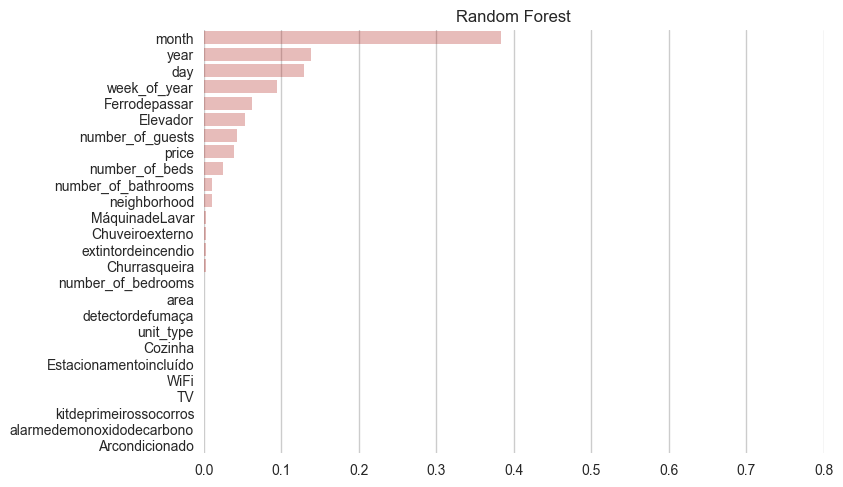

In [64]:
sns.barplot(data=temp.sort_values('rf_importances', ascending=False), x='rf_importances', y='index', color='r', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.title('Random Forest')
plt.xlabel('')
plt.ylabel('')
plt.xlim(0, 0.8);

### 6.2.2 XGBoostRegressor

In [65]:
# model definition
xgb_model = XGBRegressor()

# fiting model
xgb_fit = xgb_model.fit(X_train, y_train)

# predicting
y_hat = xgb_fit.predict(X_test)

# # metrics
metrics(y_test, y_hat)

MAE: 0.3814057579479636
RMSE: 0.4587754762444542


In [66]:
xgb_importances = xgb_fit.feature_importances_

ix = df_week.drop(['revenue','airbnb_id', 'date', 'available'], axis=1).columns

temp = pd.DataFrame(xgb_importances, index=ix, columns=['xgb_importances']).sort_values('xgb_importances', ascending=False).reset_index()

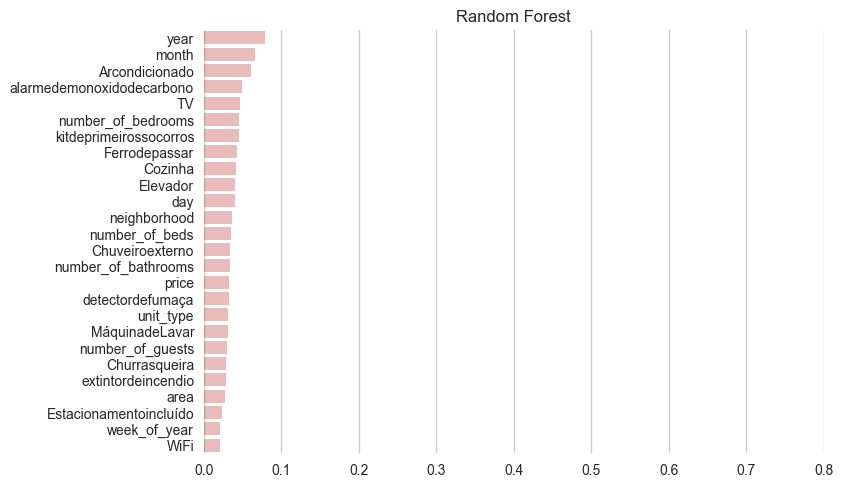

In [67]:
sns.barplot(data=temp.sort_values('xgb_importances', ascending=False), x='xgb_importances', y='index', color='r', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.title('Random Forest')
plt.xlabel('')
plt.ylabel('')
plt.xlim(0, 0.8);

## 6.3 Selections

In [68]:
cols_selected = 'neighborhood year number_of_bedrooms Arcondicionado TV Chuveiroexterno Elevador day'.split()

# 7.0 Clustering Model

## 7.1 Sample Space

### 7.1.1 T-SNE

In [69]:
# model definition
reducer = TSNE(random_state=100, n_components=2, n_jobs=-1)
embedding = reducer.fit_transform(X)

In [70]:
# embedding
X_ = pd.DataFrame()
X_[0] = embedding[:, 0]
X_[1] = embedding[:, 1]

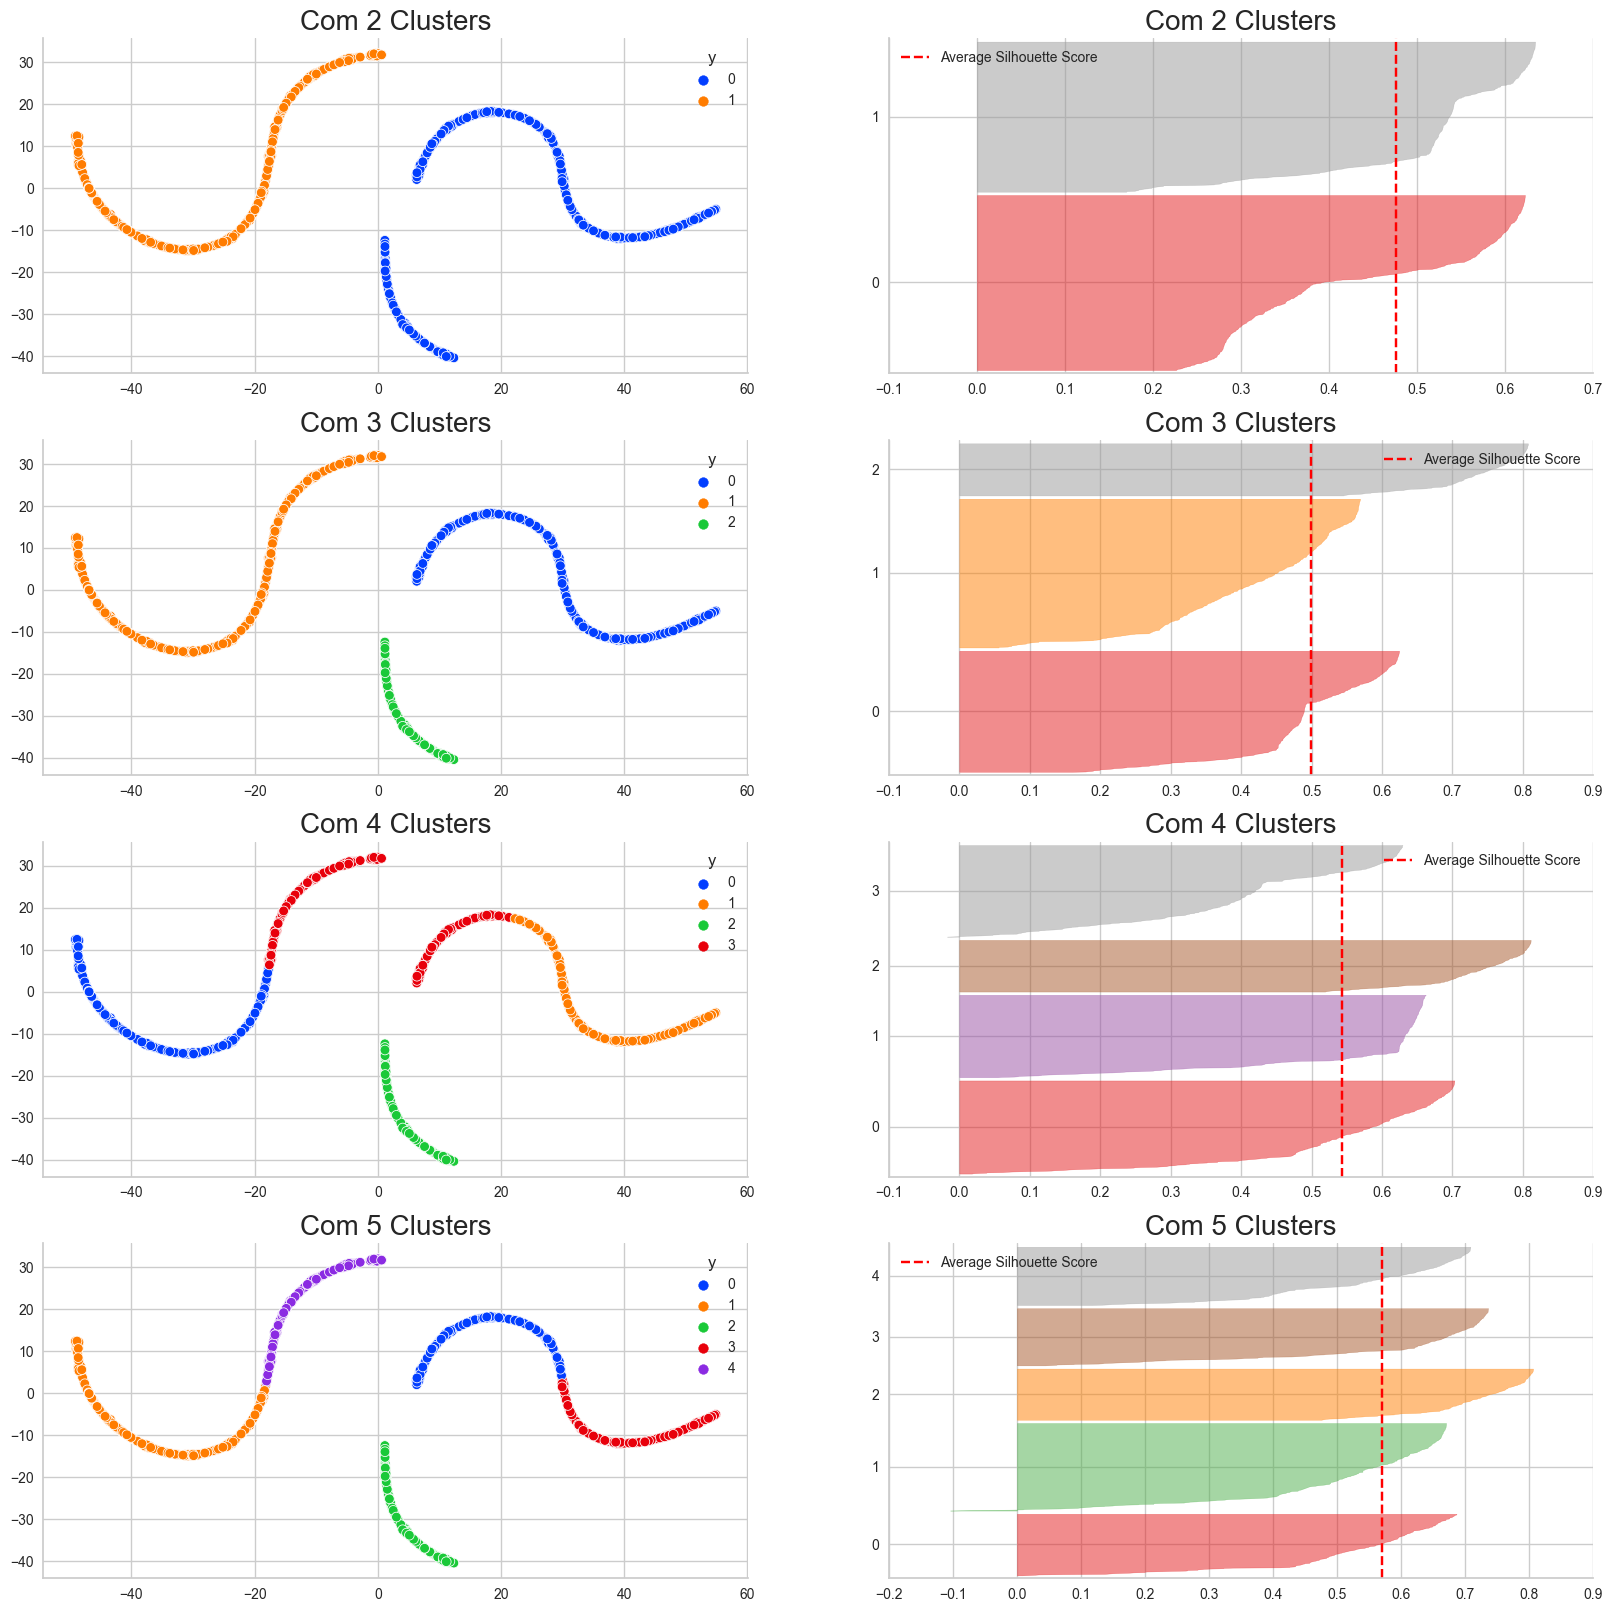

In [71]:
clusters = [2, 3, 4, 5]

plt.figure(figsize=(20, 20))
for j, i in enumerate(clusters):
    j = j + 1
    j = j * 2
    # model definition
    kmeans = c.KMeans(n_clusters=i,
                      init='k-means++',
                      n_init=10,
                      max_iter=300,
                      random_state=100)
    # model training
    kmeans.fit(X_[[0, 1]])
    X_['y'] = kmeans.labels_
    
    # dot plot
    plt.subplot(4, 2, j - 1)
    sns.scatterplot(data=X_, x=0, y=1, hue='y', palette="bright")
    plt.title(f'Com {i} Clusters', fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine()

    # silhouette visualizer
    plt.subplot(4, 2, j)
    visualizer = SilhouetteVisualizer(estimator=kmeans)
    visualizer.fit(X_[[0, 1]])
    visualizer.finalize()
    plt.title(f'Com {i} Clusters', fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine()

## 7.2 Clustering Hyperparameter Fine-tuning

### 7.2.1 Within-Cluster Sum of Square (WSS)

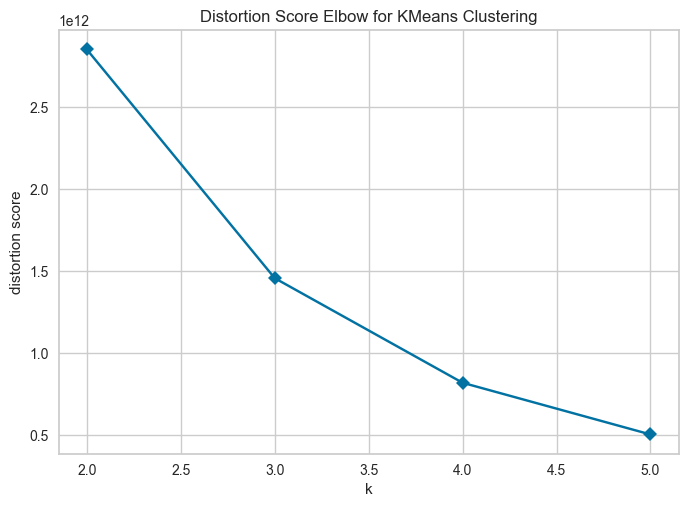

In [72]:
clusters = [2, 3, 4, 5]
kmeans = KElbowVisualizer(c.KMeans(n_init=10), k=clusters, timings=False, locate_elbow=False)
kmeans.fit(X)
kmeans.show();

### 7.2.2 Silhouette Score

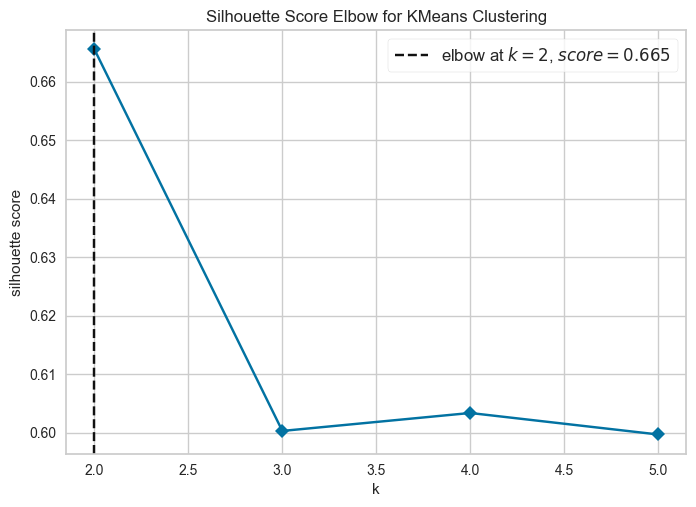

In [73]:
clusters = [2, 3, 4, 5]
kmeans = KElbowVisualizer(c.KMeans(n_init=10), metric='silhouette', k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.3 Clustering Model Training

In [74]:
k = 2

# model definition
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=100)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_
df_ref['cluster'] = labels

In [75]:
# WSS (Within-cluster sum of squares)
print(f'WSS value: {kmeans.inertia_}')

# SS (silhouette)
print(f'SS value: {m.silhouette_score(X, labels, metric="euclidean")}')

WSS value: 2853201950640.6543
SS value: 0.6654982987704657


## 7.4 Visual Inpection

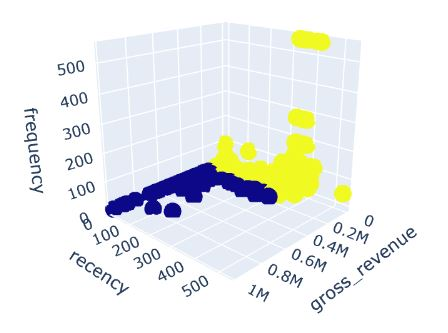

In [76]:
fig = px.scatter_3d(df_ref, x='gross_revenue', y='recency', z='frequency', color='cluster')
# fig.show()
Image('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\img\\3d_plot.jpg')

## 7.5 Cluster Profile

In [77]:
# Number of customers
profile = df_ref.groupby('cluster').agg({'airbnb_id':'count'}).reset_index().rename(columns={'airbnb_id':'number_of_customers'})
# Proportional number of customers
profile['prop_number_of_customers'] = profile['number_of_customers']  / np.sum(profile['number_of_customers'])
# Avg Gross Revenue
temp = df_ref.groupby('cluster').agg({'gross_revenue': 'mean'}).reset_index().rename(columns={'gross_revenue':'avg_gross_revenue'})
profile['avg_gross_revenue'] = temp['avg_gross_revenue']
# Proportional gross revenue
temp = df_ref.groupby('cluster').agg({'gross_revenue':'sum'}).reset_index().rename(columns={'gross_revenue':'sum_gross_revenue'})
profile['prop_gross_revenue'] = temp['sum_gross_revenue'] / np.sum(temp['sum_gross_revenue'])
# Avg Recency days
temp = df_ref.groupby('cluster').agg({'recency': 'mean'}).reset_index().rename(columns={'recency':'avg_recency_days'})
profile['avg_recency_days'] = temp['avg_recency_days']
# Avg Frequency
temp = df_ref.groupby('cluster').agg({'frequency': 'mean'}).reset_index().rename(columns={'frequency':'avg_frequency'})
profile['avg_frequency'] = temp['avg_frequency']
profile

,cluster,number_of_customers,prop_number_of_customers,avg_gross_revenue,prop_gross_revenue,avg_recency_days,avg_frequency
0,0,815,0.760261,52309.736196,0.419652,164.425767,17.574191
1,1,257,0.239739,229407.155642,0.580348,9.077821,1.929107


###### Cluster 0
* Number of customers: 809 (76% of total)
* 42% of total gross revenue
* Avarage gross revenue: 52214.25
* Avarage Recency: 164 days
* Average frequency every 18 days

###### Cluster 1
* Number of customers: 258	 (24% of total)
* 58% of total gross revenue
* Avarage gross revenue: 229030.53
* Avarage Recency: 10 days
* Average frequency every 2 days

## 7.5.1 Number of Bedrooms

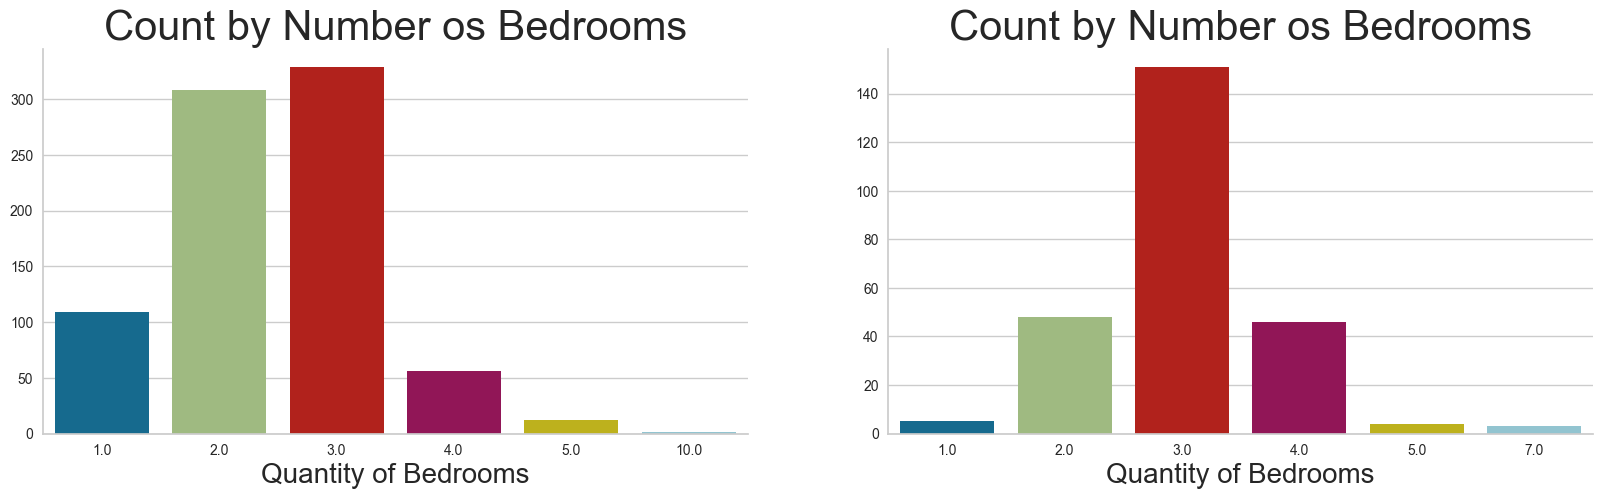

In [78]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_ref.loc[df_ref['cluster']==0] , x='number_of_bedrooms')
plt.title('Count by Number os Bedrooms', fontsize=30)
plt.xlabel('Quantity of Bedrooms', fontsize=20)
plt.ylabel('')
sns.despine()
plt.subplot(1, 2, 2)
sns.countplot(data=df_ref.loc[df_ref['cluster']==1] , x='number_of_bedrooms')
plt.title('Count by Number os Bedrooms', fontsize=30)
plt.xlabel('Quantity of Bedrooms', fontsize=20)
plt.ylabel('')
sns.despine();

## 7.5.2 Number of Bathrooms

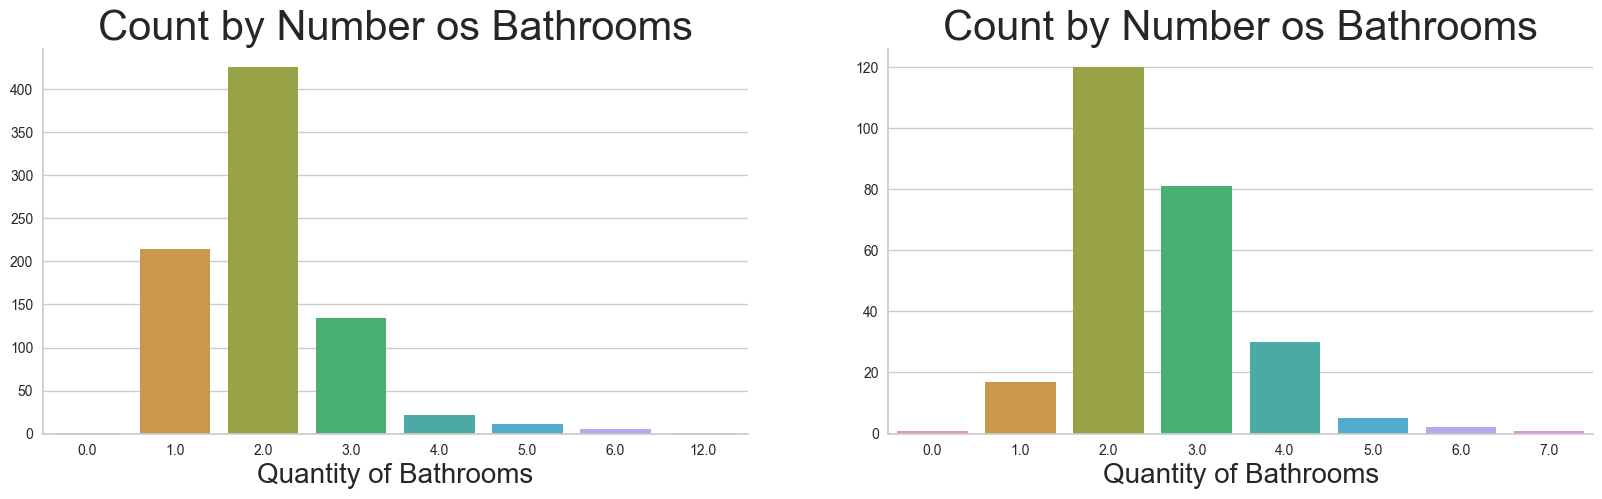

In [79]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_ref.loc[df_ref['cluster']==0] , x='number_of_bathrooms')
plt.title('Count by Number os Bathrooms', fontsize=30)
plt.xlabel('Quantity of Bathrooms', fontsize=20)
plt.ylabel('')
sns.despine()
plt.subplot(1, 2, 2)
sns.countplot(data=df_ref.loc[df_ref['cluster']==1] , x='number_of_bathrooms')
plt.title('Count by Number os Bathrooms', fontsize=30)
plt.xlabel('Quantity of Bathrooms', fontsize=20)
plt.ylabel('')
sns.despine();

## 7.5.3 Number of Beds

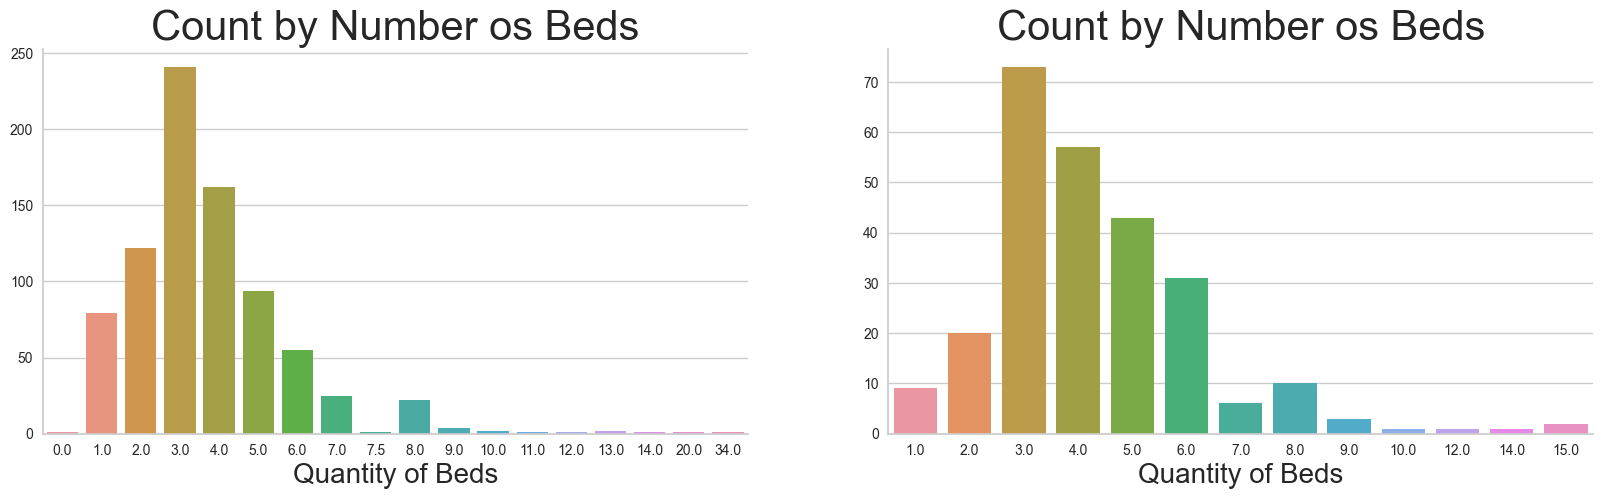

In [80]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_ref.loc[df_ref['cluster']==0] , x='number_of_beds')
plt.title('Count by Number os Beds', fontsize=30)
plt.xlabel('Quantity of Beds', fontsize=20)
plt.ylabel('')
sns.despine()
plt.subplot(1, 2, 2)
sns.countplot(data=df_ref.loc[df_ref['cluster']==1] , x='number_of_beds')
plt.title('Count by Number os Beds', fontsize=30)
plt.xlabel('Quantity of Beds', fontsize=20)
plt.ylabel('')
sns.despine();

## 7.5.4 Best Location in the City

In [81]:
neighborhood = df_ref.groupby('neighborhood').agg({'airbnb_id':'count'}).reset_index().sort_values('airbnb_id', ascending=False)

In [82]:
temp = df_ref.groupby('neighborhood').agg({'revenue':'mean'}).reset_index()
neighborhood = pd.merge(neighborhood, temp, on='neighborhood', how='left')

In [83]:
neighborhood.sort_values('revenue', ascending=False)

,neighborhood,airbnb_id,revenue
8,Ilhota,16,304.062500
2,Morretes,66,301.681818
12,Estaleirinho,8,291.750000
7,AltoSãoBento,16,271.250000
6,TabuleirodosOliveiras,18,269.722222
3,Perequê,66,251.893939
13,Sertãozinho,6,245.000000
1,Centro,151,244.198675
11,Várzea,9,238.888889
0,MeiaPraia,635,218.278740


In [84]:
neighborhood.loc[neighborhood['neighborhood']=='Morretes', 'revenue'].values / neighborhood.loc[neighborhood['neighborhood']=='MeiaPraia', 'revenue'].values

array([1.38209437])

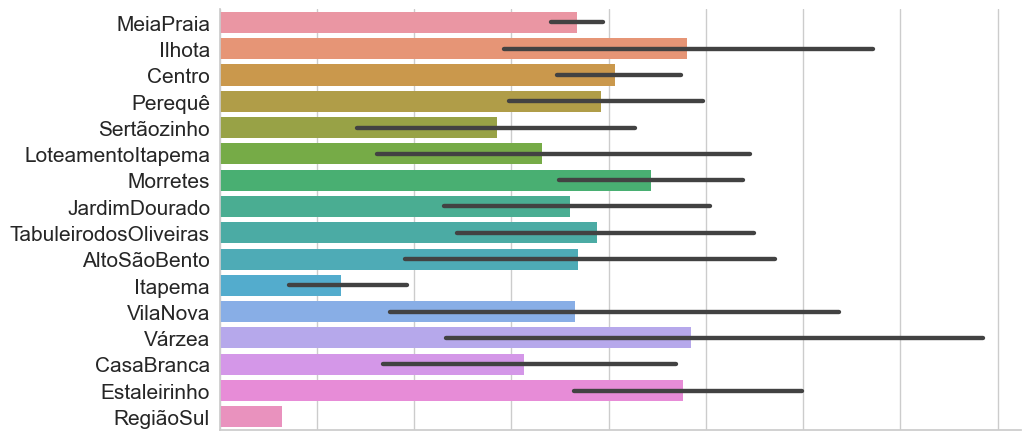

In [85]:
ax = sns.catplot(data=df_ref, x='gross_revenue', y='neighborhood', kind='bar', aspect=2, estimator='mean')
ax.tick_params(labelbottom=False, labelsize=15)
plt.ylabel('')
plt.xlabel('');

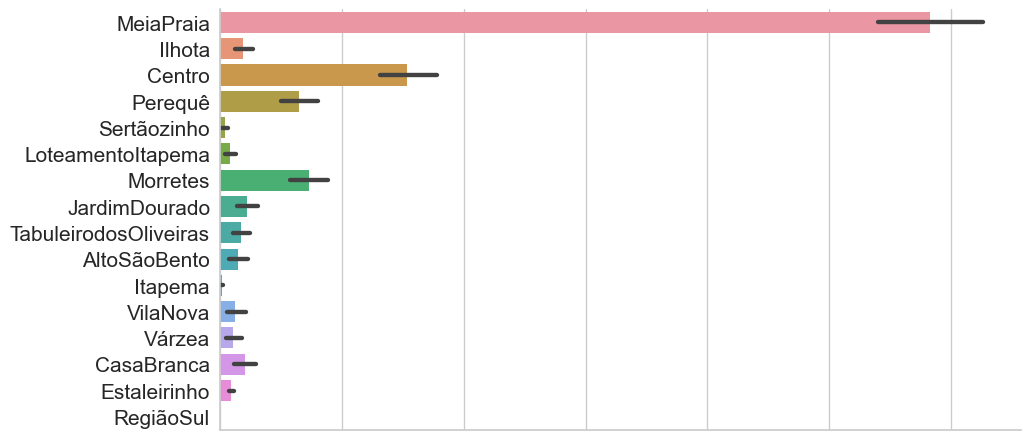

In [86]:
ax = sns.catplot(data=df_ref, x='gross_revenue', y='neighborhood', kind='bar', aspect=2, estimator='sum')
ax.tick_params(labelbottom=False, labelsize=15)
plt.ylabel('')
plt.xlabel('');

# 8.0 Machine Learning Regressor

## 8.1 Preprocessing

In [87]:
df_week = df_week[cols_selected + ['revenue', 'date']].copy()

In [88]:
# Train and Validation
X_train = df_week.loc[df_week['date'] < df_week['date'].max() - pd.Timedelta(6, 'w')].drop(['revenue', 'date'], axis=1).values
y_train = df_week.loc[df_week['date'] < df_week['date'].max() - pd.Timedelta(6, 'w'), 'revenue'].values.ravel()

X_test = df_week.loc[df_week['date'] >= df_week['date'].max() - pd.Timedelta(6, 'w')].drop(['revenue', 'date'], axis=1).values
y_test = df_week.loc[df_week['date'] >= df_week['date'].max() - pd.Timedelta(6, 'w'), 'revenue'].values.ravel()

## 8.2 Models

### 8.2.1 Linear Regression

In [89]:
# model definition
lr_model = LinearRegression()

# fiting model
lr_fit = lr_model.fit(X_train, y_train)

# predicting
y_hat = lr_fit.predict(X_test)

# # metrics
metrics(y_test, y_hat)

MAE: 0.6704473135007316
RMSE: 0.7347378493332002


#### 8.2.1.1 Cross Validation

In [90]:
error = pd.DataFrame()
error, lr_cross_validation_metrics = cross_validation(df_week, error, 5, 'Linear Regression', lr_model)

lr_cross_validation_metrics.T

D:\My Drive\Pessoal\environments\seazone\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning:

invalid value encountered in subtract



,MAE,MAPE,RMSE
Fold: 5,0.568475,inf,0.610396
Fold: 4,0.591064,inf,0.629542
Fold: 3,0.594125,inf,0.624136
Fold: 2,0.606316,inf,0.63115
Fold: 1,0.670447,inf,0.734738
mean_and_std,0.61 +/- 0.03,inf +/- nan,0.65 +/- 0.04


### 8.2.2 Lasso

In [91]:
# model definition
lasso_model = Lasso()

# fiting model
lasso_fit = lasso_model.fit(X_train, y_train)

# predicting
y_hat = lasso_fit.predict(X_test)

# # metrics
metrics(y_test, y_hat)

MAE: 0.6585788337128403
RMSE: 0.6879390904246118


#### 8.2.2.1 Cross Validation

In [92]:
error, lasso_cross_validation_metrics = cross_validation(df_week, error, 5, 'Lasso', lasso_model)

lasso_cross_validation_metrics.T

D:\My Drive\Pessoal\environments\seazone\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning:

invalid value encountered in subtract



,MAE,MAPE,RMSE
Fold: 5,0.589299,inf,0.610109
Fold: 4,0.603695,inf,0.629118
Fold: 3,0.610449,inf,0.636432
Fold: 2,0.630736,inf,0.658677
Fold: 1,0.658579,inf,0.687939
mean_and_std,0.62 +/- 0.02,inf +/- nan,0.64 +/- 0.03


### 8.2.3 Random Forest Regressor

In [93]:
# model definition
rf_model = RandomForestRegressor()

# fiting model
rf_fit = rf_model.fit(X_train, y_train)

# predicting
y_hat = rf_fit.predict(X_test)

# # metrics
metrics(y_test, y_hat)

MAE: 0.6411463457558599
RMSE: 0.7225710430662782


#### 8.2.3.1 Cross Validation

In [94]:
error, rf_cross_validation_metrics = cross_validation(df_week, error, 5, 'Random Forest', rf_model)

rf_cross_validation_metrics.T

D:\My Drive\Pessoal\environments\seazone\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning:

invalid value encountered in subtract



,MAE,MAPE,RMSE
Fold: 5,0.524801,inf,0.606814
Fold: 4,0.543787,inf,0.64861
Fold: 3,0.544043,inf,0.60435
Fold: 2,0.594284,inf,0.651966
Fold: 1,0.641226,inf,0.723316
mean_and_std,0.57 +/- 0.04,inf +/- nan,0.65 +/- 0.04


### 8.2.4 XGBoost Regressor

In [95]:
# model definition
xgb_model = XGBRegressor()

# fiting model
xgb_fit = xgb_model.fit(X_train, y_train)

# predicting
y_hat = xgb_fit.predict(X_test)

# # metrics
metrics(y_test, y_hat)

MAE: 0.6317324885202622
RMSE: 0.7055903026757849


#### 8.2.4.1 Cross Validation

In [96]:
error, xgb_cross_validation_metrics = cross_validation(df_week, error, 5, 'XGBoost Regressor', xgb_model)

xgb_cross_validation_metrics.T

D:\My Drive\Pessoal\environments\seazone\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning:

invalid value encountered in subtract



,MAE,MAPE,RMSE
Fold: 5,0.555643,inf,0.627127
Fold: 4,0.563124,inf,0.652122
Fold: 3,0.547457,inf,0.591016
Fold: 2,0.565881,inf,0.613036
Fold: 1,0.631732,inf,0.70559
mean_and_std,0.57 +/- 0.03,inf +/- nan,0.64 +/- 0.04


## 8.3 Model Performance

### 8.3.1 Machine Learning Performance

In [97]:
error.T

,MAE,MAPE,RMSE
Linear Regression,0.61 +/- 0.03,inf +/- nan,0.65 +/- 0.04
Lasso,0.62 +/- 0.02,inf +/- nan,0.64 +/- 0.03
Random Forest,0.57 +/- 0.04,inf +/- nan,0.65 +/- 0.04
XGBoost Regressor,0.57 +/- 0.03,inf +/- nan,0.64 +/- 0.04


## 8.4 Business Performance

In [98]:
cols = 'year month date revenue number_of_bedrooms number_of_bathrooms neighborhood'.split()

In [ ]:
# # Train and Validation
# X_train = df_week_.loc[df_week_['date'] < df_week_['date'].max() - pd.Timedelta(6, 'w')].drop(['revenue', 'date'], axis=1).values
# y_train = df_week_.loc[df_week_['date'] < df_week_['date'].max() - pd.Timedelta(6, 'w'), 'revenue'].values.ravel()

# X_test = df_week_.loc[df_week_['date'] >= df_week_['date'].max() - pd.Timedelta(6, 'w')].drop(['revenue', 'date'], axis=1).values
# y_test = df_week_.loc[df_week_['date'] >= df_week_['date'].max() - pd.Timedelta(6, 'w'), 'revenue'].values.ravel()

In [ ]:
# # model definition
# xgb_model = XGBRegressor()

# # fiting model
# xgb_fit = xgb_model.fit(X_train, y_train)

# # predicting
# y_hat = xgb_fit.predict(X_test)

# # # metrics
# metrics(y_test, y_hat)

In [ ]:
# error, xgb_cross_validation_metrics = cross_validation(df_week_, error, 5, 'XGBoost Regressor', xgb_model)

# xgb_cross_validation_metrics.T

# 9.0 Results and Conclusions

## Business Question 1: What is the best property profile to invest in the city?
### The best property profile to invest in the city:
* Localized at Morretes (average revenue 38% higher than Meia Praia and reasonable demand)
* 3 badrooms
* 2 bathrooms

## Business Question 2: Which is the best location in the city in terms of revenue?
*  Ilhota (considering the average just revenue, without considering the demand)

## Business Question 3: What are the characteristics and reasons for the best revenues in the city?

* Distance from the beach
* Neighborhood
* Bedrooms quantities
* Elevator

## Business Question 4: We would like to build a building of 50 apartments in the city, where should we build it and how should the apartments be designed in order to be a great investment?

* Localized at Meia Praia (best demand)
* 3 badrooms
* 2 bathrooms

## Business Question 5: How much will be the return on investment of this building in the years 2024, 2025 and 2026?

# Time

In [ ]:
print(f'Total processing time: {round((time.time() - time_init) / 60, 1)}')